In [4]:
# Standard libraries
import pandas as pd
import numpy as np
import pickle

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#sk

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate

#machine Learning
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [9]:
hec = pd.read_csv('phl_exoplanet_catalog.csv')
hec.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [10]:
planets = pd.read_csv('exoplanets.csv')
planets.head()


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,5/14/2014,2008-01,5/14/2014
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,7/23/2014,2011-08,7/23/2014
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,4/25/2018,2009-10,5/14/2014
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,9/4/2018,2017-03,9/6/2018
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,4/25/2018,2011-08,7/23/2014


In [11]:
planets.isnull().sum()


pl_name             0
hostname            0
default_flag        0
sy_snum             0
sy_pnum             0
                 ... 
sy_gaiamagerr1    600
sy_gaiamagerr2    600
rowupdate           1
pl_pubdate          0
releasedate         0
Length: 92, dtype: int64

In [12]:
target_count = hec['P_HABITABLE'].value_counts()
'''
0 --> not habitable
1 --> conservative
2 --> optimistic
'''
target_count

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [13]:
# drop not habitable planets
hec = hec[hec.P_HABITABLE != 0]

In [14]:
# create habitable column for planets data with the help of hec dataframe
# get names of planets
habitable_planets = hec.P_NAME.values
planets['habitable'] = planets['pl_name'].isin(habitable_planets)

In [15]:
target_count = planets['habitable'].value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')

Class 0: 29331
Class 1: 346
Percentage of Majority Class: 98.83
Percentage of Minority Class: 1.17


In [16]:
# remove columns with more than 40% missing data
def remove_missing(f):
    count = len(planets[planets[f].isnull()])
    if count/len(planets) > 0.4:
        return 1
    else:
        return 0
    
missing_values = [x for x in planets.columns if remove_missing(x)]
planets = planets.drop(missing_values, axis=1)

In [17]:
planets.describe()

,default_flag,sy_snum,sy_pnum,disc_year,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmaxlim,...,sy_disterr2,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
count,29677.000000,29677.000000,29677.000000,29677.000000,29677.000000,2.691700e+04,2.603100e+04,2.603000e+04,26921.000000,18827.000000,...,28235.000000,29345.000000,29332.000000,29331.000000,29323.000000,29175.000000,29175.000000,29077.000000,29077.000000,29077.000000
mean,0.149409,1.079725,1.914614,2014.514742,0.001617,7.043570e+02,1.753710e+02,-1.672337e+02,-0.000223,-0.000159,...,-27.142584,13.799757,0.122418,-0.123324,11.783149,0.035182,-0.034638,13.569900,0.000524,-0.000524
std,0.356497,0.298566,1.206276,3.083720,0.040185,6.622335e+04,2.281722e+04,2.281121e+04,0.021112,0.012623,...,115.672302,2.321143,0.154699,0.193401,2.222954,0.178544,0.167672,2.250167,0.001164,0.001164
min,0.000000,1.000000,1.000000,1989.000000,0.000000,9.070629e-02,0.000000e+00,-3.650000e+06,-1.000000,-1.000000,...,-2900.000000,0.872000,0.001000,-12.270000,-3.044000,0.011000,-11.140000,2.926270,0.000122,-0.063232
25%,0.000000,1.000000,1.000000,2014.000000,0.000000,4.768310e+00,9.630000e-06,-2.157000e-04,0.000000,0.000000,...,-22.195000,12.991000,0.057000,-0.137000,11.151000,0.020000,-0.035000,12.835800,0.000254,-0.000506
50%,0.000000,1.000000,1.000000,2016.000000,0.000000,1.118720e+01,4.319000e-05,-4.318000e-05,0.000000,0.000000,...,-8.810000,14.358000,0.092000,-0.092000,12.395000,0.024000,-0.024000,14.175800,0.000352,-0.000352
75%,0.000000,1.000000,2.000000,2016.000000,0.000000,2.795000e+01,2.160000e-04,-9.650000e-06,0.000000,0.000000,...,-2.685000,15.322000,0.137000,-0.057000,13.214000,0.035000,-0.020000,15.105800,0.000506,-0.000254
max,1.000000,4.000000,8.000000,2021.000000,1.000000,8.040000e+06,3.650000e+06,0.000000e+00,1.000000,0.000000,...,2700.000000,45.340000,11.000000,-0.001000,35.330000,9.995000,-0.011000,20.186100,0.063232,-0.000122


In [18]:
# most planet numbers in a stellar system
planets['sy_pnum'].nlargest(10)

4524    8
4525    8
4526    8
4527    8
4528    8
4529    8
4530    8
4531    8
4532    8
4533    8
Name: sy_pnum, dtype: int64

<AxesSubplot:title={'center':'Class Count'}>

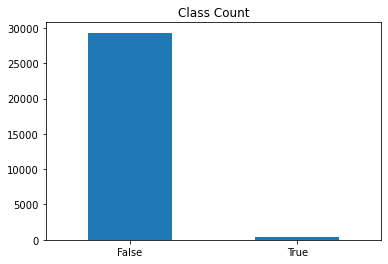

In [19]:
# target class's distribution
target_count = planets['habitable'].value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0)

Text(0.5, 1.0, 'Temperature - Mass Relation with Habitability')

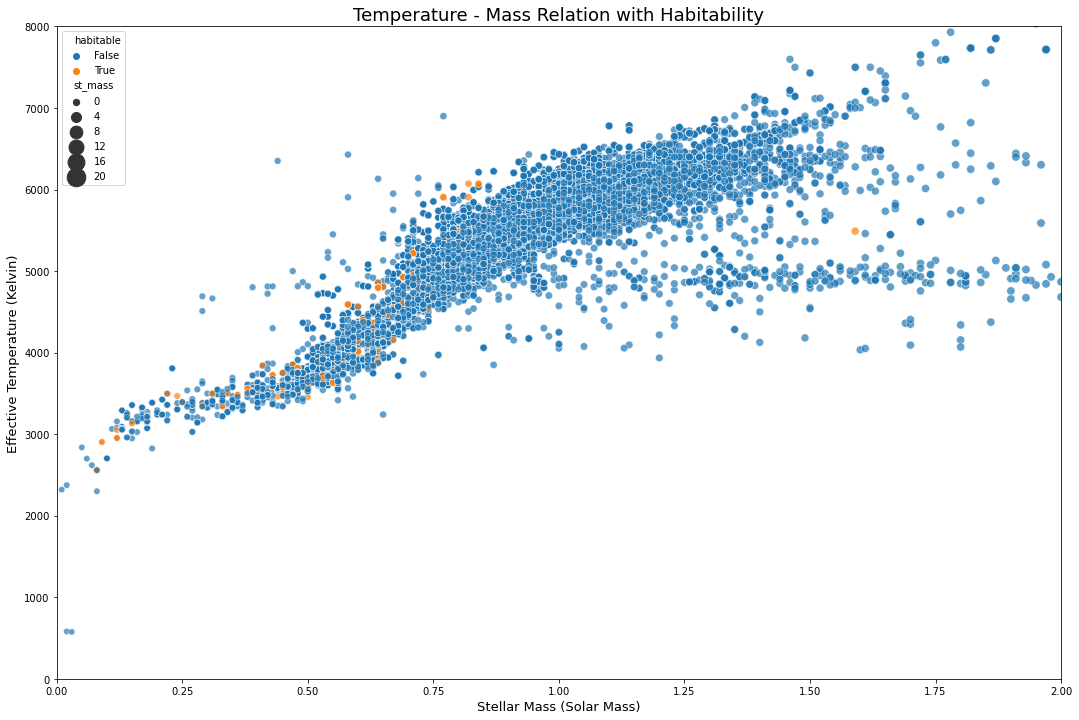

In [20]:
plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x='st_mass', y='st_teff',
                     hue='habitable', size='st_mass',
                     sizes=(40, 400), alpha=.7,
                     data=planets)
# limiting x and y axis's values
ax.axis([0,2, 0, 8000])
ax.set_xlabel('Stellar Mass (Solar Mass)', fontsize=13)
ax.set_ylabel('Effective Temperature (Kelvin)', fontsize=13)
ax.set_title('Temperature - Mass Relation with Habitability', fontsize=18)

Text(0, 0.5, 'Dec [decimal degrees]')

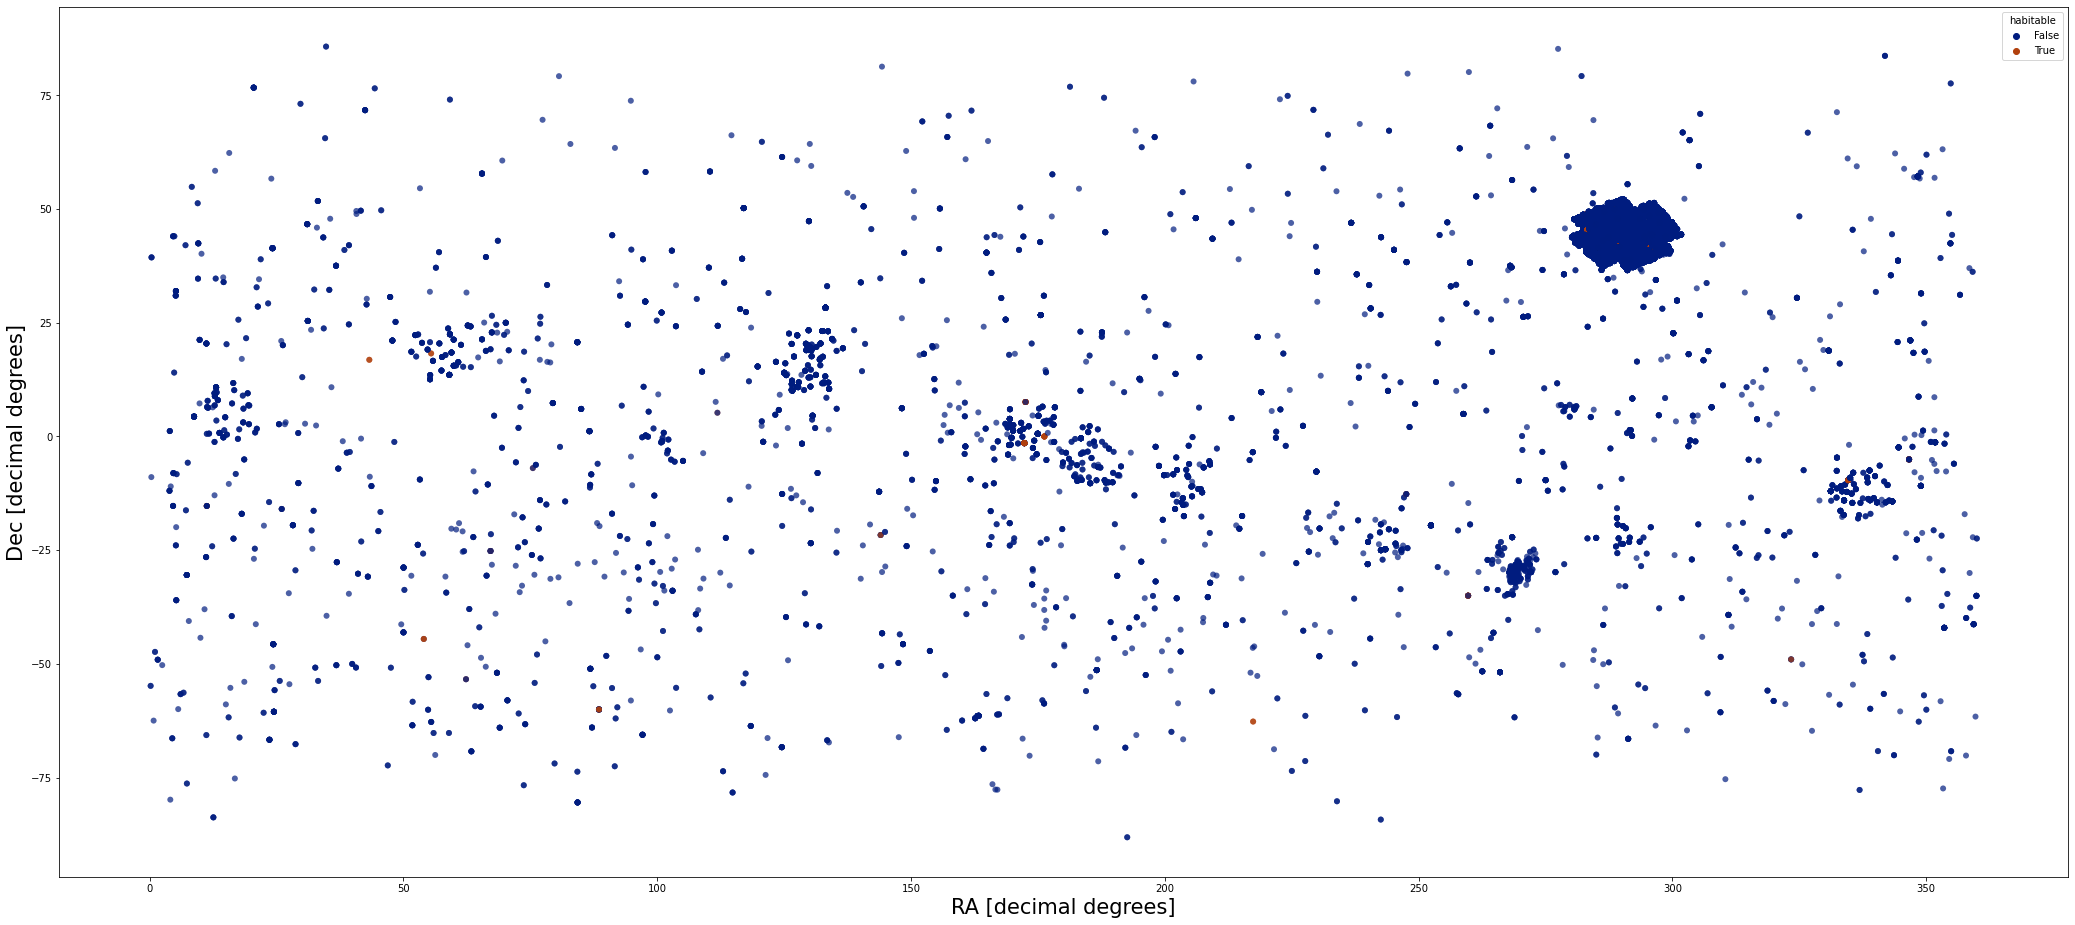

In [21]:
plt.figure(figsize=(36, 16))
sns.scatterplot(x="ra", y="dec",
                hue="habitable", alpha=.7,
                palette='dark', 
                sizes=(1, 8), linewidth=0,
                data=planets)
plt.xlabel('RA [decimal degrees]', fontsize=21)
plt.ylabel('Dec [decimal degrees]', fontsize=21)

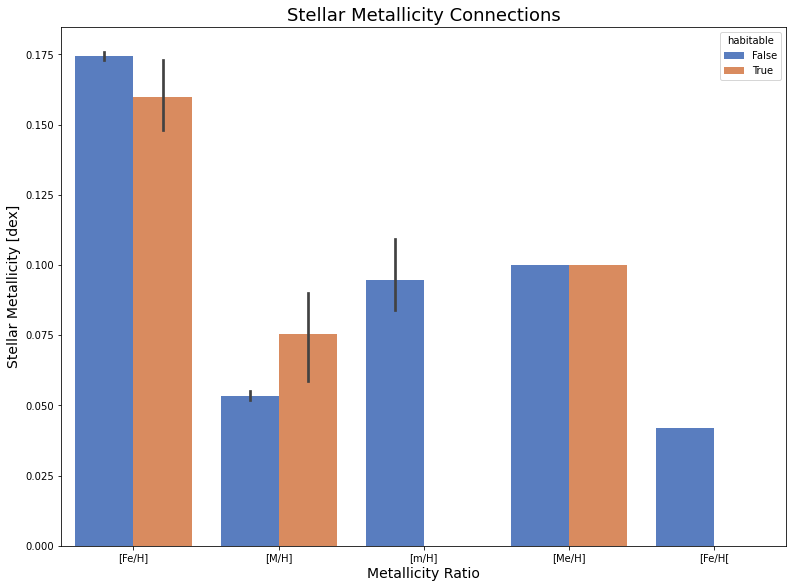

In [22]:
plt.figure(figsize=(13, 21))
plt.subplot(211)
m = sns.barplot(x="st_metratio", y="st_meterr1", hue="habitable", data=planets,
                palette="muted")
plt.xlabel('Metallicity Ratio', fontsize=14)
plt.ylabel('Stellar Metallicity [dex]', fontsize=14)
plt.title('Stellar Metallicity Connections', fontsize=18)


plt.show()

In [66]:
corr_mtrx = planets.corr()
corr_df = pd.DataFrame(corr_mtrx['habitable'].sort_values(ascending=False))
corr_df.head(10)

,habitable
habitable,1.000000
pl_controv_flag,0.167483
st_logg,0.085014
sy_vmagerr1,0.077766
sy_gaiamagerr1,0.062235
st_loggerr2,0.052526
sy_vmag,0.048072
sy_pnum,0.044381
sy_gaiamag,0.035404
st_tefferr2,0.027730


In [81]:
planets_c = planets[['sy_dist', 'habitable', 'st_mass']]
planets_c.drop(planets_c[planets_c.habitable != 1].index, inplace=True)

In [75]:
planets_c['dist_to_star_ly'] = planets_c['sy_dist'] * 3.26
"""
The Voyager 1 spacecraft is on an interstellar mission. It is traveling away from the Sun at a rate of 17.3 km/s. It means
62280 km/h. 
1 light year = 9.4605284 × 10^12 kilometers
1 year = 8760 hours
1 speed of light = 1079252848.8 km/h
""" 
planets_c['minimum_travel_time_year'] = (((planets_c['dist_to_star_ly'] * 9.461e12) / 62280) / 8760)
planets_c.head()

,sy_dist,habitable,st_mass,dist_to_star_ly,minimum_travel_time_year
379,3.672780,True,0.12,11.973263,2.076332e+05
380,3.672780,True,0.12,11.973263,2.076332e+05
418,15.128500,True,NaN,49.318910,8.552593e+05
432,5.921535,True,0.29,19.304204,3.347621e+05
452,20.190300,True,0.42,65.820378,1.141418e+06


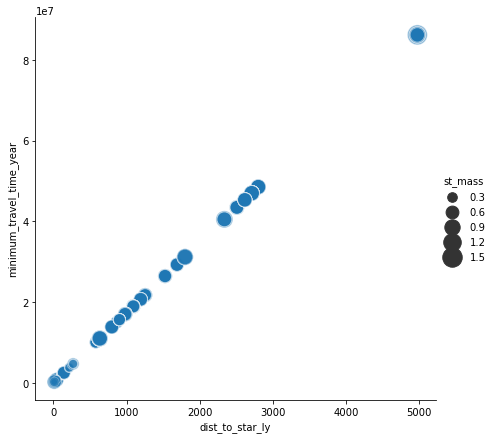

In [26]:
sns.relplot(x="dist_to_star_ly", y="minimum_travel_time_year", size="st_mass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=planets_c)

In [87]:

planets_c = planets.copy()


In [88]:
planets_c[['pl_rade', 'pl_orbper']] = planets[['pl_rade', 'pl_orbper']]

# Reorder columns
planets_c = planets_c[[ 'pl_rade', 'pl_orbper', 'st_teff',
                       'st_mass', 'st_rad', 'st_met', 'st_logg', 
                        'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2', 'habitable']]

planets_c.describe()


,pl_rade,pl_orbper,st_teff,st_mass,st_rad,st_met,st_logg,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
count,20836.000000,2.691700e+04,27975.000000,25227.000000,28084.000000,18960.000000,24521.000000,29077.000000,29077.000000,29077.000000
mean,4.727759,7.043570e+02,5468.334439,0.945506,1.142886,-0.030804,4.413511,13.569900,0.000524,-0.000524
std,58.445336,6.622335e+04,1000.040454,0.319634,1.722876,0.226288,0.285306,2.250167,0.001164,0.001164
min,0.270000,9.070629e-02,575.000000,0.000000,0.010000,-2.500000,1.100000,2.926270,0.000122,-0.063232
25%,1.550000,4.768310e+00,5106.000000,0.820000,0.790000,-0.160000,4.320000,12.835800,0.000254,-0.000506
50%,2.260000,1.118720e+01,5613.000000,0.960000,0.950000,-0.019000,4.470000,14.175800,0.000352,-0.000352
75%,3.154750,2.795000e+01,5949.920000,1.070000,1.200000,0.120000,4.570000,15.105800,0.000506,-0.000254
max,3791.050000,8.040000e+06,57000.000000,23.560000,83.800000,0.740000,7.920000,20.186100,0.063232,-0.000122


In [106]:
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE, ADASYN


frames = [planets_c, corr_df]
planets_d = pd.concat(frames)


0.8.0


In [100]:
planets_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29727 entries, 0 to st_teff
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_rade         20836 non-null  float64
 1   pl_orbper       26917 non-null  float64
 2   st_teff         27975 non-null  float64
 3   st_mass         25227 non-null  float64
 4   st_rad          28084 non-null  float64
 5   st_met          18960 non-null  float64
 6   st_logg         24521 non-null  float64
 7   sy_gaiamag      29077 non-null  float64
 8   sy_gaiamagerr1  29077 non-null  float64
 9   sy_gaiamagerr2  29077 non-null  float64
 10  habitable       29727 non-null  float64
dtypes: float64(11)
memory usage: 2.7+ MB


In [103]:
# Basic validation: splitting the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(planets_c.iloc[:, :-1], planets_d.loc[:, 'habitable'], test_size=0.25,random_state=76)
X_train.shape # shape of my train set

ValueError: Found input variables with inconsistent numbers of samples: [29677, 29727]

In [104]:
# Resampling imbalanced data
X_smoted, y_smoted = SMOTE(sampling_strategy='minority', random_state=76).fit_resample(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').